<a href="https://colab.research.google.com/github/vggls/M.Sc._AI_Thesis/blob/main/experiments/breakhis_resnet50/ResNet50_training_%26_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Imports**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cv2
import plotly.graph_objects as go
from PIL import Image as PImage
import os
import shutil
import copy
import pickle
import random

In [ ]:
from torchvision import transforms, datasets, models
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [ ]:
# custom written code
from breakhis_slide_allocation import allocate_slides_to_datasets
from breakhis_binary import create_datasets, summaries
from training_loop import Train
from train_model import fit
from imbalanced import class_weights
#from vgg19 import VGG19
from resnet import ResNet
from testing_report import Test_Report
from plot_tensor import convert_for_plot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **2. Download from Kaggle**

In [ ]:
! mkdir ~/.kaggle/
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ambarish/breakhis

100% 3.98G/3.99G [03:17<00:00, 24.2MB/s]
100% 3.99G/3.99G [03:17<00:00, 21.7MB/s]


In [ ]:
! unzip breakhis.zip

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-026.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-027.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-028.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-029.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-030.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-031.png  
  inflating: BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/

# **3. Create training, validation and test datasets**

In [ ]:
#shutil.rmtree('training_dataset')
#shutil.rmtree('validation_dataset')
#shutil.rmtree('test_dataset')

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])
# to be applied to validation and test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor([0.5, 0.5, 0.5]), torch.Tensor([0.5, 0.5, 0.5]))
])

In [ ]:
training_dataset, validation_dataset, test_dataset = create_datasets(train_transforms, test_transforms)

No benign slides overlap in training, validation and test sets!
No malignant slides overlap in training, validation and test sets!


In [ ]:
training_dataset.class_to_idx

{'benign': 0, 'malignant': 1}

In [ ]:
labels = training_dataset.class_to_idx
summaries(labels, True)

**As explained in the [Kaggle page](https://www.kaggle.com/datasets/ambarish/breakhis) the dataset consists of 2480 benign and 5429 malignant samples. As per above breakdown one can verify that the suggested data allocation (as per breakhis_slide_allocation.py and breakhis.py) preserves the number of samples.
This is also proven via the calcultion of section 4 (Class distribution).**


# **4. Class distribution**

In [ ]:
classes = ['benign', 'malignant']
total = []

for clas in classes:
    class_points = 0
    for dataset in ['training_dataset', 'validation_dataset', 'test_dataset']:
        class_path = os.path.join(dataset, clas)
        class_images = os.listdir(class_path)
        class_points += len(class_images)
    total.append(class_points)

fig = go.Figure()
for i, clas in enumerate(classes):
    percent = round(total[i] / sum(total) * 100, 2)
    text = f"{total[i]} ({percent}%)"
    fig.add_trace(go.Bar(x=[clas.capitalize()], y=[total[i]], text=[text], textposition='outside', showlegend=False, marker=dict(color="steelblue")))

fig.update_layout(width=450, height=550, title='BreakHis Dataset: Class distribution', title_x=0.5)
fig.show()

# **5. Dataset visualization**

<Figure size 432x288 with 0 Axes>

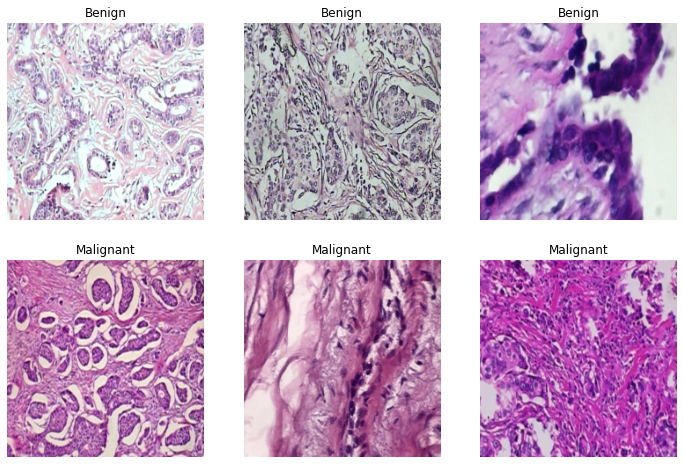

In [ ]:
plt.figure()

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for i, clas in enumerate(['benign', 'malignant']):
    tensors = [tensor for (tensor, label) in test_dataset if label==i]

    ints = random.sample(range(len(tensors)), 3)     #select 3 random tensors

    ax[i, 0].imshow(convert_for_plot(tensors[ints[0]])); ax[i, 0].set_title(clas.capitalize()); ax[i, 0].axis('off')
    ax[i, 1].imshow(convert_for_plot(tensors[ints[1]])); ax[i, 1].set_title(clas.capitalize()); ax[i, 1].axis('off')
    ax[i, 2].imshow(convert_for_plot(tensors[ints[2]])); ax[i, 2].set_title(clas.capitalize()); ax[i, 2].axis('off')

plt.show()

# **6. ResNet50**

In [ ]:
weights = class_weights('./training_dataset', training_dataset)

benign class - instances 1436 - assigned weight 0.0006963788300835655
malignant class - instances 3414 - assigned weight 0.00029291154071470416


In [ ]:
resnet50 = ResNet(type_ = '50',
                  no_of_classes = 2,
                  trainable_layers = None)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.



>**training**

In [ ]:
loss_fct = torch.nn.CrossEntropyLoss(weights.cuda())
optimizer = optim.Adam(resnet50.model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

training_dict, validation_dict = fit(train_dataset=training_dataset,
                                     validation_dataset=validation_dataset,
                                     batch_size=16,
                                     model=resnet50,
                                     loss_fct=loss_fct,
                                     optimizer=optimizer,
                                     scheduler=scheduler,
                                     epochs=12,
                                     patience=None,
                                     no_of_classes=2,
                                     labels_of_normal_classes=None)

Device: cuda:0
Starting training..
-----------------------------------
Epoch 1/12
->Training phase
  lr value 0.0001
  Loss=0.5141
  Accuracy=0.79
->Validation phase
  Loss=0.8606
  Accuracy=0.76
-----------------------------------
Epoch 2/12
->Training phase
  lr value 5e-05
  Loss=0.3732
  Accuracy=0.85
->Validation phase
  Loss=0.7752
  Accuracy=0.78
-----------------------------------
Epoch 3/12
->Training phase
  lr value 2.5e-05
  Loss=0.3266
  Accuracy=0.87
->Validation phase
  Loss=0.7851
  Accuracy=0.78
-----------------------------------
Epoch 4/12
->Training phase
  lr value 1.25e-05
  Loss=0.2940
  Accuracy=0.89
->Validation phase
  Loss=0.7516
  Accuracy=0.78
-----------------------------------
Epoch 5/12
->Training phase
  lr value 6.25e-06
  Loss=0.2879
  Accuracy=0.88
->Validation phase
  Loss=0.7649
  Accuracy=0.79
-----------------------------------
Epoch 6/12
->Training phase
  lr value 3.125e-06
  Loss=0.2776
  Accuracy=0.89
->Validation phase
  Loss=0.8104
  Accura

In [ ]:
drive_path = './drive/MyDrive/Colab_Notebooks/dataset_models/BreakHis/Models/'

resnet50 = torch.load('model_epoch12.pt')

torch.save(resnet50, drive_path + 'breakhis_resnet50.pt')

with open(drive_path + 'breakhis_resnet50_training_dict.pickle', 'wb') as f:
  pickle.dump(training_dict, f)
with open(drive_path + 'breakhis_resnet50_validation_dict.pickle', 'wb') as f:
  pickle.dump(validation_dict, f)

>**loss history plot**

In [ ]:
import pickle
drive_path = './drive/MyDrive/Colab_Notebooks/dataset_models/BreakHis/Models/'

with open(drive_path + "breakhis_resnet50_training_dict.pickle", "rb") as f:
    training_dict = pickle.load(f)
with open(drive_path + "breakhis_resnet50_validation_dict.pickle", "rb") as f:
    validation_dict = pickle.load(f)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, len(training_dict['loss'])+1 )), y=training_dict['loss'], name='Training'))
fig.add_trace(go.Scatter(x=list(range(1, len(validation_dict['loss'])+1 )), y=validation_dict['loss'], name='Validation'))
fig.update_layout(title='ResNet50 Loss history',
                  title_x=0.5,
                   xaxis_title='Epochs',
                   yaxis_title='Loss',
                  height=400, width=800,)
fig.show()

>**testing**

In [ ]:
from torch.utils.data import DataLoader
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

test_report = Test_Report(test_loader, resnet50, labels.keys())

Device: cuda:0


In [ ]:
print('\033[1m' + 'Model: breakhis_resnet50.pt' + '\033[0m \n')
test_report.classification_report()
bal_acc = test_report.balanced_accuracy()
print(f'Balanced Accuracy Score: {round(bal_acc, 2)}')

Model: breakhis_resnet50.pt 

              precision    recall  f1-score   support

      benign       0.71      0.93      0.80       532
   malignant       0.96      0.80      0.87      1025

    accuracy                           0.85      1557
   macro avg       0.83      0.87      0.84      1557
weighted avg       0.87      0.85      0.85      1557

Balanced Accuracy Score: 0.87


In [ ]:
print('\033[1m' + 'Model: breakhis_resnet50.pt' + '\033[0m')
scores = test_report.roc_curve_and_scores(plot=True)
print(f'Mean AUC score: {round(sum(scores)/len(scores),3)}')
_ = test_report.pr_curve_and_scores(plot=True)

Model: breakhis_resnet50.pt


Mean AUC score: 0.942
